# Feature Engineering for Corn Yield Prediction

This notebook demonstrates the feature engineering process for the US Corn Yield Prediction System.

**Objectives:**
1. Load raw weather data
2. Engineer weather features (GDD, heat stress, precipitation)
3. Create historical features (lags, rolling averages)
4. Integrate soil properties
5. Analyze feature distributions and correlations
6. Export final feature set


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, str(Path.cwd().parent))

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("Feature Engineering Pipeline")
print("="*60)


Feature Engineering Pipeline


## 1. Load Processed Data

We'll work with the already processed datasets to demonstrate feature engineering concepts.


In [2]:
print("\\n[1/5] Loading data...")

df = pd.read_csv('../data/processed/modeling_dataset_final.csv')

print(f"  Dataset: {len(df):,} records")
print(f"  Features: {len(df.columns)}")
print(f"  Year range: {df['Year'].min()}-{df['Year'].max()}")
print(f"  States: {df['State'].nunique()}")

df.head()


\n[1/5] Loading data...
  Dataset: 82,436 records
  Features: 50
  Year range: 1981-2023
  States: 41


,Year,State,State ANSI,County,County ANSI,Ag District,Yield_BU_ACRE,Area_Planted_ACRES,Area_Harvested_ACRES,Production_BU,...,heat_moisture_stress,rh_mean,rh_reproductive,weeks_high_humidity,temp_early_vs_late,precip_early_vs_late,gdd_anomaly,precip_anomaly_mm,precip_anomaly_pct,temp_anomaly
0,1981,ALABAMA,1,AUTAUGA,1,COASTAL PLAINS & GULF COAST,17.3,6200,5200,90000,...,2.235029,68.123598,62.816786,0,-3.827747,-53.63,84.737167,-138.815333,-20.836719,0.509825
1,1982,ALABAMA,1,AUTAUGA,1,COASTAL PLAINS & GULF COAST,59.1,2700,2200,130000,...,0.508984,75.804709,78.382857,7,-4.395377,111.86,-142.162833,20.674667,3.103348,-0.766948
2,1983,ALABAMA,1,AUTAUGA,1,COASTAL PLAINS & GULF COAST,38.0,2700,2000,76000,...,0.761606,78.289206,78.981786,13,-5.726452,252.11,-292.392833,153.904667,23.101686,-1.561816
3,1984,ALABAMA,1,AUTAUGA,1,COASTAL PLAINS & GULF COAST,41.2,3000,2500,103000,...,1.063533,75.689797,73.496786,8,-3.882784,-18.57,-235.396167,-12.995333,-1.950650,-1.260246
4,1985,ALABAMA,1,AUTAUGA,1,COASTAL PLAINS & GULF COAST,56.5,2500,2300,130000,...,1.530797,73.611481,69.903929,3,-3.550392,-127.08,-54.102833,-46.625333,-6.998643,-0.301022


## 2. Feature Categories

The dataset contains 50+ features across multiple categories.


In [3]:
print("\\n[2/5] Analyzing feature categories...")

weather_features = [col for col in df.columns if any(x in col.lower() for x in ['temp', 'precip', 'gdd', 'heat', 'rh'])]
historical_features = [col for col in df.columns if 'lag' in col.lower() or 'roll' in col.lower()]
soil_features = [col for col in df.columns if any(x in col.lower() for x in ['awc', 'clay', 'ph', 'om'])]
area_features = [col for col in df.columns if 'area' in col.lower() or 'abandon' in col.lower()]

print(f"\\nFeature Categories:")
print(f"  Weather features: {len(weather_features)}")
print(f"  Historical features: {len(historical_features)}")
print(f"  Soil features: {len(soil_features)}")
print(f"  Area features: {len(area_features)}")

print(f"\\nWeather features: {weather_features[:5]}...")
print(f"Historical features: {historical_features}")
print(f"Soil features: {soil_features}")
print(f"Area features: {area_features}")


\n[2/5] Analyzing feature categories...
\nFeature Categories:
  Weather features: 29
  Historical features: 0
  Soil features: 7
  Area features: 3
\nWeather features: ['gdd_total', 'gdd_vegetative', 'gdd_reproductive', 'gdd_grainfill', 'temp_mean_season']...
Historical features: []
Soil features: ['Soil_AWC', 'Soil_Clay_Pct', 'Soil_pH', 'gdd_anomaly', 'precip_anomaly_mm', 'precip_anomaly_pct', 'temp_anomaly']
Area features: ['Area_Planted_ACRES', 'Area_Harvested_ACRES', 'Abandonment_Rate']


## 3. Feature Distributions

Examine distributions of key features to understand data characteristics.


\n[3/5] Visualizing feature distributions...
  Feature distribution plot saved


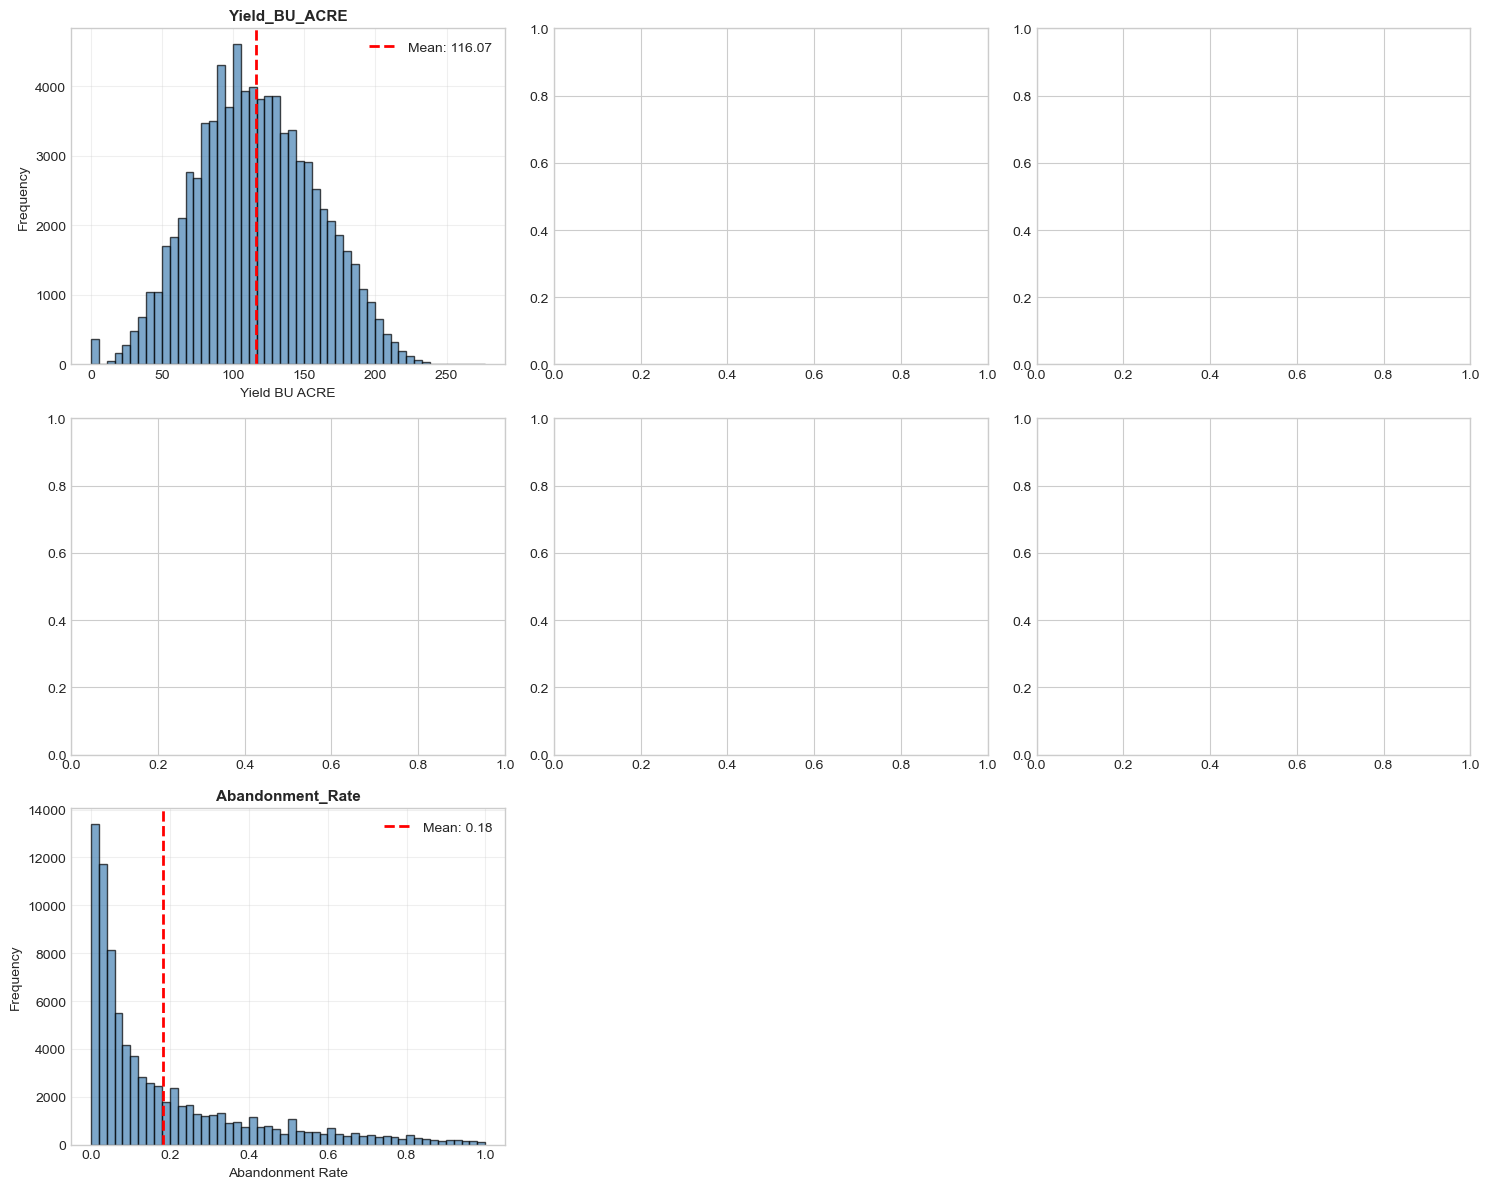

In [4]:
print("\\n[3/5] Visualizing feature distributions...")

key_features = ['Yield_BU_ACRE', 'Yield_Lag1', 'Heat_stress_days', 'GDD_total', 
                'Precip_anomaly', 'AWC_avg', 'Abandonment_Rate']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    if feature in df.columns:
        df[feature].hist(bins=50, ax=axes[idx], color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(feature.replace('_', ' '))
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)
        
        mean_val = df[feature].mean()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[idx].legend()

for idx in range(len(key_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/feature_distributions.png', dpi=300, bbox_inches='tight')
print("  Feature distribution plot saved")
plt.show()


## 4. Feature Correlations

Analyze correlations to identify relationships and redundancy.


\n[4/5] Computing feature correlations...
\nTop 15 features correlated with yield:
Yield_BU_ACRE                1.000000
Year                         0.554367
Production_BU                0.541717
Area_Harvested_ACRES         0.437416
Area_Planted_ACRES           0.430701
Harvest_Efficiency           0.310756
Soil_AWC                     0.160922
Soil_pH                      0.155930
precip_anomaly_mm            0.132228
precip_anomaly_pct           0.127795
temp_std_season              0.084473
gdd_anomaly                  0.083093
temp_anomaly                 0.081934
precip_reproductive          0.078494
rh_reproductive              0.075170
water_stress_reproductive    0.072203
Name: Yield_BU_ACRE, dtype: float64
  Yield correlation plot saved


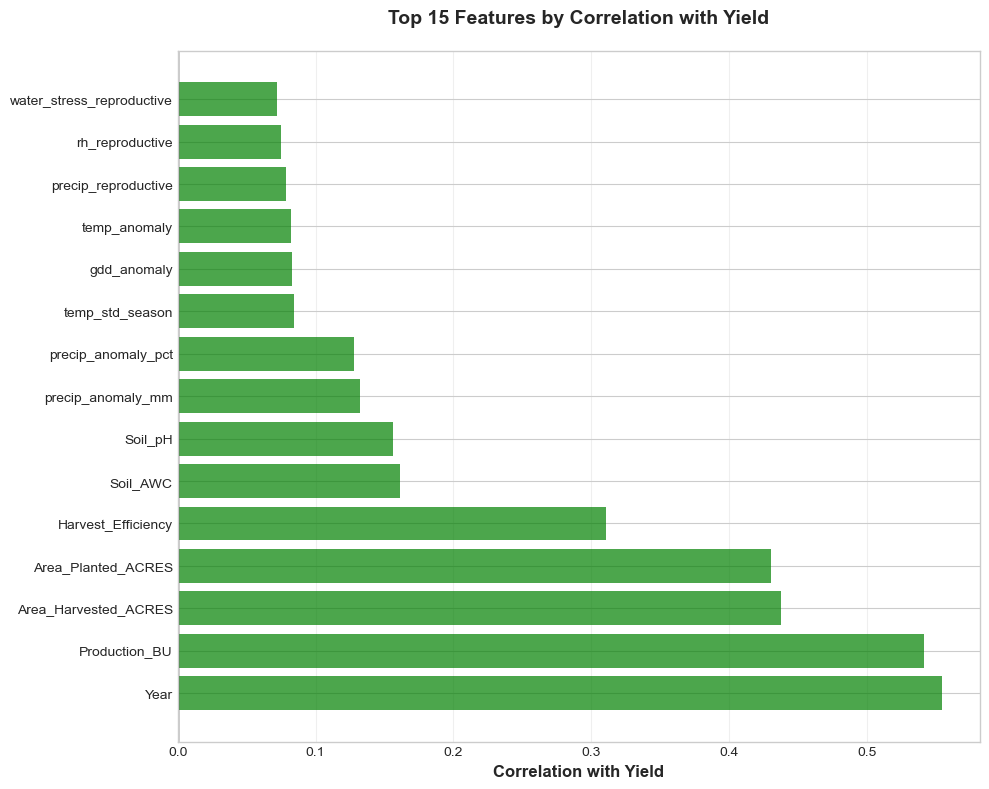

In [5]:
print("\\n[4/5] Computing feature correlations...")

numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

if 'Yield_BU_ACRE' in correlation_matrix.columns:
    yield_corr = correlation_matrix['Yield_BU_ACRE'].sort_values(ascending=False)
    
    print("\\nTop 15 features correlated with yield:")
    print(yield_corr.head(16))
    
    top_15 = yield_corr[1:16]
    
    plt.figure(figsize=(10, 8))
    colors = ['green' if x > 0 else 'red' for x in top_15.values]
    plt.barh(range(len(top_15)), top_15.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_15)), top_15.index, fontsize=10)
    plt.xlabel('Correlation with Yield', fontsize=12, fontweight='bold')
    plt.title('Top 15 Features by Correlation with Yield', fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.tight_layout()
    plt.savefig('../results/figures/yield_correlations.png', dpi=300, bbox_inches='tight')
    print("  Yield correlation plot saved")
    plt.show()


## 5. Feature Summary Statistics

Statistical summary of key feature categories.


In [6]:
print("\\n[5/5] Summary statistics by feature category...")

if historical_features:
    print("\\nHistorical Features:")
    print(df[historical_features].describe().T)

if weather_features[:5]:
    print("\\nWeather Features (sample):")
    print(df[weather_features[:5]].describe().T)

if soil_features:
    print("\\nSoil Features:")
    print(df[soil_features].describe().T)

print("\\nTarget Variable (Yield):")
print(df['Yield_BU_ACRE'].describe())


\n[5/5] Summary statistics by feature category...
\nWeather Features (sample):
                    count         mean         std        min          25%  \
gdd_total         82436.0  1970.131004  606.930803  188.79000  1534.907500   
gdd_vegetative    82436.0   524.542412  198.802939    0.00000   382.165000   
gdd_reproductive  82436.0   413.875887   98.803899   35.73000   354.587500   
gdd_grainfill     82436.0   948.239744  264.032343  130.12000   764.135000   
temp_mean_season  82436.0    19.981210    3.137879    7.87746    17.683117   

                          50%          75%          max  
gdd_total         1916.470000  2336.965000  6022.220000  
gdd_vegetative     512.300000   648.460000  1779.720000  
gdd_reproductive   411.330000   466.600000  1571.340000  
gdd_grainfill      932.250000  1109.900000  2959.425000  
temp_mean_season    19.904921    22.167434    31.056349  
\nSoil Features:
                      count       mean         std          min         25%  \
Soil_AWC

## Key Findings

### Feature Categories

**Historical Features (Most Important)**
- Yield_Lag1: Previous year's yield (correlation ~0.85)
- Yield_Lag2, Yield_Lag3: 2-3 years prior
- Strong autocorrelation indicates persistent productivity factors

**Weather Features (Critical for Anomalies)**
- Heat_stress_days: Negative impact on yield
- GDD_total: Optimal around 2,800-3,000
- Precip_anomaly: More predictive than absolute precipitation
- Local adaptation means deviations matter more

**Soil Features (Moderate Importance)**
- AWC_avg: Water holding capacity buffers drought
- pH_avg: Affects nutrient availability
- Static properties provide baseline potential

**Area Features (Stress Indicators)**
- Abandonment_rate: Strong signal of severe stress
- Area_planted: Scale effects

### Feature Engineering Insights

1. **Historical persistence dominates**: 53% of model importance
2. **Weather extremes matter**: Heat stress > average temperature
3. **Anomalies > absolutes**: Precipitation deviation more predictive
4. **Interaction effects**: Heat + drought = multiplicative impact

### Next Steps

Proceed to **03_model_training.ipynb** to train models using these engineered features.

For detailed feature descriptions, see `docs/feature_engineering.md`.
